In [206]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config

# Notas

Gradient of EBK based exclusively to the reconstruction...

In [315]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = UnmixingLoss()
    # criterion = nn.MSELoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)
    
    X = dataset[:]
    volume_reg = SimplexVolumeLoss(X, n_endmembers).to(device)
    # similarity_reg = SimilarityLoss(n_endmembers, temperature=1e-1)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=5e-2)


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 1e-1
    simplex_weight = 1e-3
    similarity_weight = 1e-1

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*volume_reg(sigmoid(model.ebk)) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        # scheduler.step()
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [316]:
from torch.utils.data import Dataset
from torch import tensor
import scipy.io as sio
import numpy as np

class HSIDataset(Dataset):
    def __init__(self):
        super(HSIDataset, self).__init__()

    def preprocessing(self, X:np.ndarray):
        '''
            Preprocessing the dataset for removing high-frequency noise. 
            This preprocessing consists of three steps:
                1. Median filter in the spatial domain.
                2. Moving average filter in the spectral domain.
                3. Normalization of the data.

            Parameters
            ----------
                X : np.ndarray, shape (nRow, nCol, nBand)
                    HSI Cube.
        '''

        from skimage.filters import median
        from utils import moving_average

        max_value = X.max()

        X = median(X, footprint=np.ones((3,3,1)))
        # X = moving_average(X.reshape(-1, X.shape[-1]), 3, padding_size=2).reshape(X.shape[0], X.shape[1], -1)
        X = X / (max_value + 1e-3)
        return X

class JasperRidge(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(JasperRidge, self).__init__()
        data = sio.loadmat(os.path.join(root_dir, 'jasperRidge2_R198.mat'))
        y = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'GroundTruth/end4.mat'))

        self.n_row, self.n_col = data['nRow'].item(), data['nCol'].item()

        self.X = data['Y'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
        self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        self.X = tensor(self.X, dtype=torch.float32)

        self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
        self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
        self.n_bands = self.X.shape[1]
        self.n_endmembers = self.E.shape[0]
        
        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.reshape(self.n_row, self.n_col, -1)

    def image(self):
        return self.X.reshape(self.n_row, self.n_col, -1)


In [317]:
dataset = JasperRidge(config.JasperRidge_PATH)

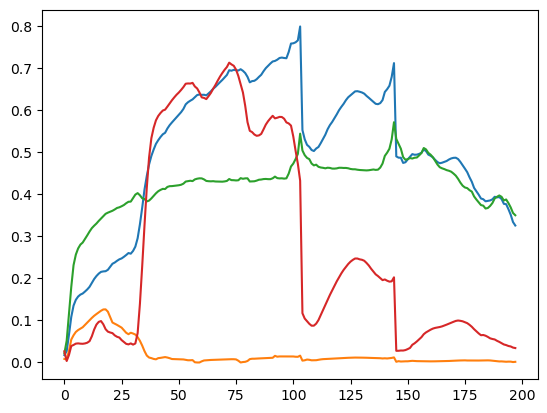

In [318]:
from HySpecLab.eea import VCA
n_endmembers = dataset.n_endmembers + 0
vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=128)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))
    
plt.plot(endmember_init.T)
plt.show()

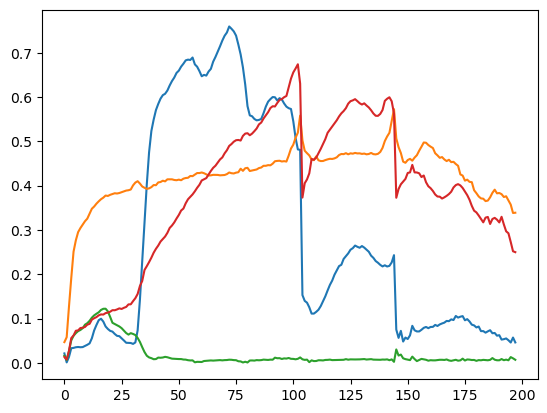

In [319]:
from pysptools import eea

ee = eea.NFINDR()
endmember = ee.extract(dataset.image().numpy(), n_endmembers)
endmember_init = torch.from_numpy(endmember).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

plt.plot(endmember_init.T)
plt.show()

In [320]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=8, n_epochs=100, lr=1e-3)

100%|██████████| 100/100 [00:12<00:00,  7.78epoch/s, tls=0.1008]


# Test

In [321]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=1e-1)

In [322]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0514) tensor(0.3469) tensor(2.9902) tensor(0.4185)


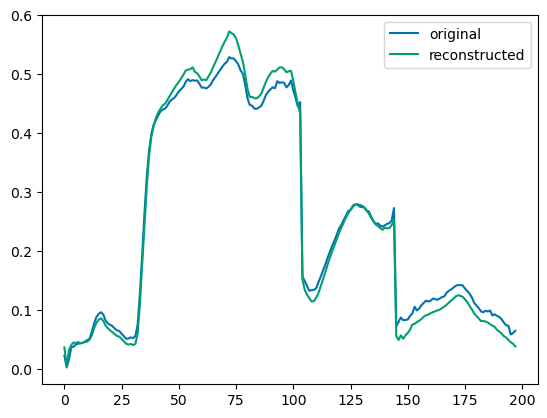

In [323]:
with plt.style.context(("seaborn-colorblind")):
    plt.plot(_X[1020].cpu(), label='original')
    plt.plot(reconstruc[1020].cpu().detach(), label='reconstructed')
    plt.legend()

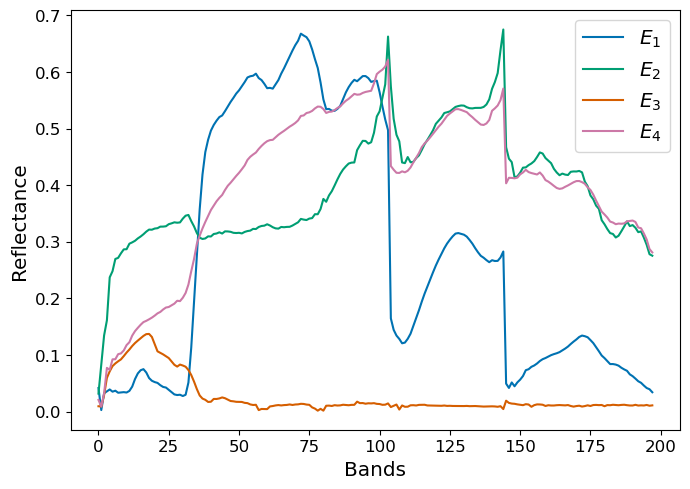

In [324]:
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(sigmoid(model.ebk).detach().cpu().numpy().T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    plt.legend(fontsize='x-large')
    plt.xticks(fontsize='large')
    plt.yticks(fontsize='large')
    plt.tight_layout()
    plt.show()


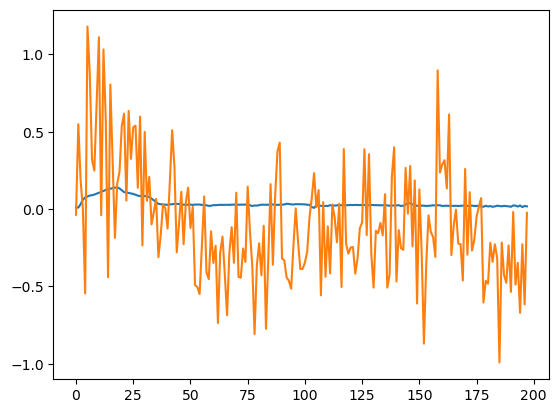

In [325]:
x = dataset[5012:5018]
model.eval()
out = model.projection(model.encoder(x))

plt.plot(x[1].cpu(), label='original')
plt.plot(out[1].cpu().detach(), label='reconstructed')

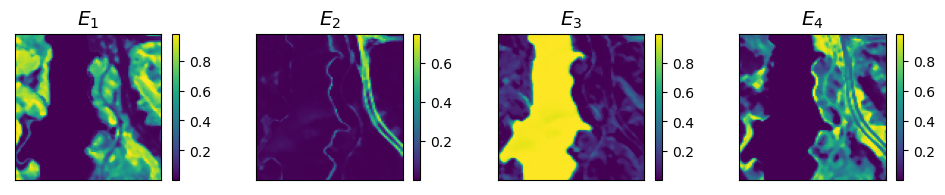

In [326]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(100, 100, n_endmembers)
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,7))
    for i in range(n_endmembers):
        plt.subplot(4,5,i+1)
        # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max())
        plt.imshow(test[:,:,i].T)
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[i], fontsize='x-large')
        plt.colorbar()

    plt.tight_layout()
    plt.show()

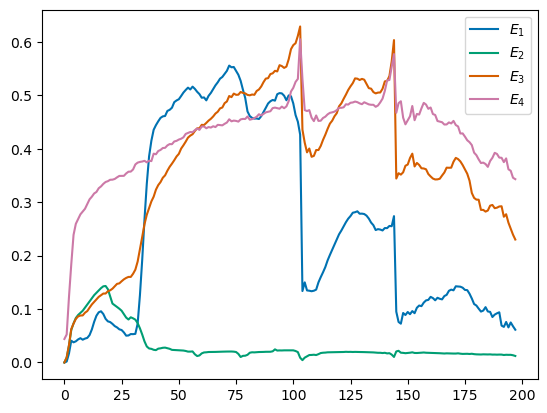

In [327]:
test = dataset.endmembers()
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))
with plt.style.context(("seaborn-colorblind")):
    plt.plot(test.T)
    plt.legend(labels)
    plt.show()

In [331]:
ebk = sigmoid(model.ebk).detach().cpu()
endmembers = dataset.endmembers()

from HySpecLab.metrics import sad
test = sad(ebk, endmembers)

print(test)
print(torch.argmin(test, dim=1))



tensor([[0.0711, 1.1814, 0.4933, 0.6240],
        [0.6314, 0.9018, 0.2528, 0.1306],
        [1.2541, 0.1360, 1.1963, 1.0165],
        [0.4494, 1.0503, 0.0510, 0.1915]])
tensor([0, 3, 1, 2])


In [334]:
abundance = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(100, 100, n_endmembers)
abundance_gt = dataset.abundance().numpy()

# compare using root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

test = rmse(abundance[:,:,0], abundance_gt[:,:,0])
print(test)

0.09634105


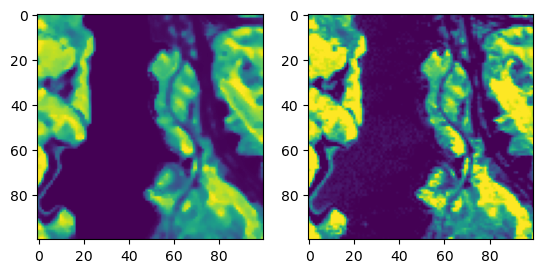

In [335]:
plt.subplot(1,2,1)
plt.imshow(abundance[:,:,0].T)
plt.subplot(1,2,2)
plt.imshow(abundance_gt[:,:,0].T)
plt.show()

In [ ]:
from torch.nn.functional import normalize
x = ebk
y = endmembers

x = normalize(x, dim=1)
y = normalize(y, dim=1) 

bs, n_bands = x.shape
y = y.expand(bs, -1, -1)

# # targets_norm = torch.norm(y, dim=2)
# #normalize x
# y_normalize = torch.nn.functional.normalize(y, dim=2)
# x_normalize = torch.nn.functional.normalize(x, dim=1)
# # print(torch.norm(y, dim=2), torch.norm(y_normalize, dim=2))

# # print(torch.norm(x, dim=1), torch.norm(x_normalize, dim=1))
# # inputs_norm = torch.norm(x, dim=1).unsqueeze(1).expand_as(y_normalize)
# print(x.shape, x_normalize.shape)
# print(y.shape, y_normalize.shape)
# x_normalize = x_normalize.unsqueeze(1)

summation = torch.bmm(x.view(bs, 1, n_bands), torch.transpose(y, 1, 2)).squeeze()
# summation = torch.matmul(x.view(bs, 1, n_bands), torch.transpose(y, 1, 2))
print(torch.acos(summation)) 
# # Using Hard Tanh to force values between [-1, 1] because $cos^{-1}(x)$ where $x \in [-1,1]$
# torch.acos((summation / (inputs_norm * targets_norm)))

In [ ]:
x.view(bs, 1, n_bands)

In [ ]:
x_normalize.shape

In [ ]:
ebk.shape

In [ ]:
# plt.plot(logit_endmember_init[0])
plt.plot(model.ebk.detach().cpu().numpy().T, label=labels)
plt.legend()


In [ ]:
torch.sigmoid(torch.arange(-2, 2, 0.1))

In [ ]:
test = (dataset.A @ dataset.E).reshape(dataset.n_row, dataset.n_col, -1)
print(test.shape)
plt.imshow(test[:,:,0])

In [ ]:
import scipy.io as sio

mat = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'jasperRidge2_R198.mat'))
mat['Y']

In [ ]:
y = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'GroundTruth/end4.mat'))
endmember = y['M']
abundance = y['A']

from matplotlib import pyplot as plt

with plt.style.context(("seaborn-colorblind")):
    plt.plot(endmember[:])

abundance = abundance.reshape(-1, mat['nRow'].item(), mat['nCol'].item())
plt.imshow(abundance[0,:,:].T)

In [ ]:
endmember.shape

In [ ]:
abundance.shape

In [ ]:
os.path.join(config.JasperRidge_PATH, 'GroundTruth/end4.mat')